In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
train=pd.read_csv("emails.csv", delimiter=",")
test=pd.read_csv("emailsTest.csv", delimiter=",")
print(train)

                                                   text  spam
0     Subject: naturally irresistible your corporate...     1
1     Subject: the stock trading gunslinger  fanny i...     1
2     Subject: unbelievable new homes made easy  im ...     1
3     Subject: 4 color printing special  request add...     1
4     Subject: do not have money , get software cds ...     1
...                                                 ...   ...
5723  Subject: re : research and development charges...     0
5724  Subject: re : receipts from visit  jim ,  than...     0
5725  Subject: re : enron case study update  wow ! a...     0
5726  Subject: re : interest  david ,  please , call...     0
5727  Subject: news : aurora 5 . 2 update  aurora ve...     0

[5728 rows x 2 columns]


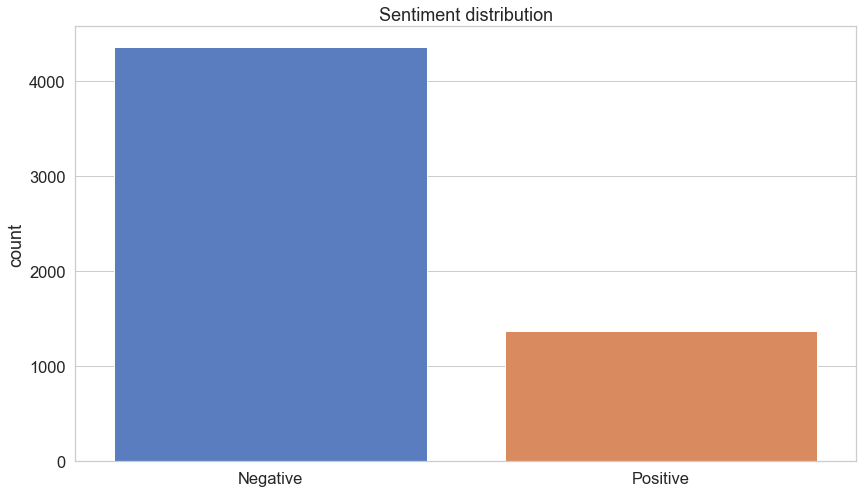

In [3]:
f = sns.countplot(x='spam', data=train)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

In [4]:
print(train)

                                                   text  spam
0     Subject: naturally irresistible your corporate...     1
1     Subject: the stock trading gunslinger  fanny i...     1
2     Subject: unbelievable new homes made easy  im ...     1
3     Subject: 4 color printing special  request add...     1
4     Subject: do not have money , get software cds ...     1
...                                                 ...   ...
5723  Subject: re : research and development charges...     0
5724  Subject: re : receipts from visit  jim ,  than...     0
5725  Subject: re : enron case study update  wow ! a...     0
5726  Subject: re : interest  david ,  please , call...     0
5727  Subject: news : aurora 5 . 2 update  aurora ve...     0

[5728 rows x 2 columns]


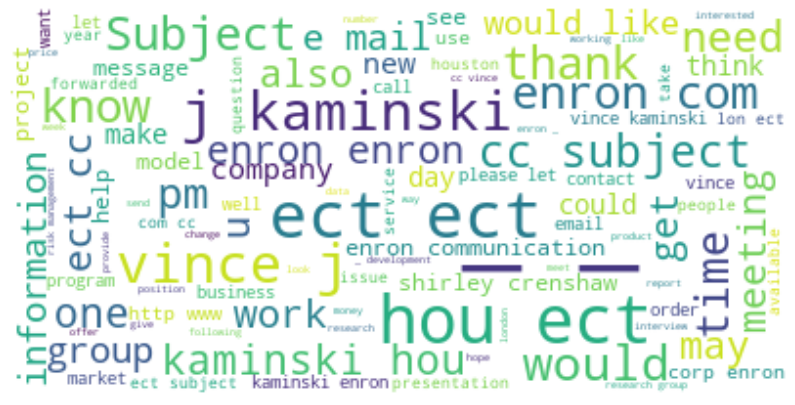

In [5]:
text = " ".join(text for text in train.text)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [24]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [25]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [26]:
X = train['review'].values
y = train['sentiment'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [27]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

In [28]:
y_hat = MNB.predict(X_test)

In [29]:
accuracy_score(y_test, y_hat)

0.8556

In [30]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2481
           1       0.83      0.90      0.86      2519

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [31]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix

array([[2021,  460],
       [ 262, 2257]])

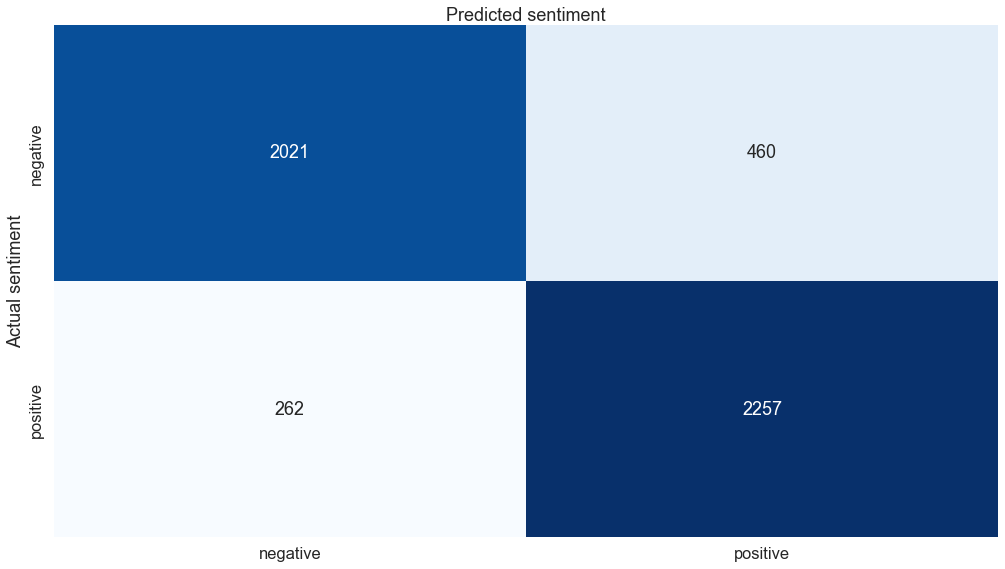

In [32]:
class_names = ["negative", "positive"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');